###Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

###Load the Dataset

In [5]:
data = Path('/delhi_metro_updated.csv')
df_raw = pd.read_csv(data)
df_raw.shape, df_raw.head()

((150000, 10),
    TripID        Date         From_Station            To_Station  Distance_km  \
 0   59771  2022-05-08             Inderlok         Kashmere Gate        12.94   
 1   21363  2023-01-12           Model Town        Dilshad Garden         2.33   
 2  127325  2023-07-13     Kashmere Gate     Netaji Subhash Place         5.56   
 3  140510  2022-11-10        Chandni Chowk             Hauz Khas         4.02   
 4  144298  2022-11-06          Rajiv Chowk        Kalkaji Mandir         9.66   
 
      Fare  Cost_per_passenger  Passengers   Ticket_Type      Remarks  
 0   77.99               18.27        13.0    Smart Card  maintenance  
 1   35.89               83.71        15.0  Tourist Card  maintenance  
 2   64.35               43.70         9.0        Single     off-peak  
 3  144.13               14.98        27.0           NaN  maintenance  
 4  104.96               83.84        23.0        Single     off-peak  )

###Normalize the column names & Detect key columns

In [6]:
def normalize_col(col):
    c = col.strip().lower()
    for ch in [' ', '/', '\\', '-', '(', ')', '.', ',', ':', ';', '[', ']', '{', '}', '&', '%', '#', '@', '!']:
        c = c.replace(ch, '_')
    while '__' in c:
        c = c.replace('__', '_')
    return c.strip('_')

df_raw.columns = [normalize_col(c) for c in df_raw.columns]
cols = df_raw.columns.tolist()
df_raw.columns


Index(['tripid', 'date', 'from_station', 'to_station', 'distance_km', 'fare',
       'cost_per_passenger', 'passengers', 'ticket_type', 'remarks'],
      dtype='object')

In [7]:
def find_first_column(candidates, cols):
    for cand in candidates:
        if cand in cols:
            return cand
    for c in cols:
        for cand in candidates:
            if cand in c:
                return c
    return None

date_col      = find_first_column(['date', 'journey_date', 'travel_date'], cols)
from_col      = find_first_column(['from_station', 'source', 'from'], cols)
to_col        = find_first_column(['to_station', 'destination', 'to'], cols)
ticket_col    = find_first_column(['ticket_type', 'ticket', 'pass_type'], cols)
distance_col  = find_first_column(['distance_km', 'distance', 'km'], cols)
fare_col      = find_first_column(['fare', 'ticket_price', 'amount'], cols)
passenger_col = find_first_column(['passengers', 'ridership'], cols)
line_col      = find_first_column(['line', 'corridor'], cols)
phase_col     = find_first_column(['phase', 'phase_no', 'project_phase'], cols)
station_col   = find_first_column(['station', 'station_name', 'name'], cols)

print("Detected columns:")
print("date_col     :", date_col)
print("from_col     :", from_col)
print("to_col       :", to_col)
print("ticket_col   :", ticket_col)
print("distance_col :", distance_col)
print("fare_col     :", fare_col)
print("passenger_col:", passenger_col)
print("line_col     :", line_col)
print("phase_col    :", phase_col)
print("station_col  :", station_col)


Detected columns:
date_col     : date
from_col     : from_station
to_col       : to_station
ticket_col   : ticket_type
distance_col : distance_km
fare_col     : fare
passenger_col: passengers
line_col     : None
phase_col    : None
station_col  : from_station


###Data Health Check

In [9]:
print("=== INFO ===")
display(df_raw.info())

print("\n=== MISSING (%) ===")
missing = df_raw.isna().mean().sort_values(ascending=False) * 100
display(missing.head(20))


=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tripid              150000 non-null  int64  
 1   date                150000 non-null  object 
 2   from_station        150000 non-null  object 
 3   to_station          150000 non-null  object 
 4   distance_km         150000 non-null  float64
 5   fare                150000 non-null  float64
 6   cost_per_passenger  150000 non-null  float64
 7   passengers          148500 non-null  float64
 8   ticket_type         148500 non-null  object 
 9   remarks             123743 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 11.4+ MB


None


=== MISSING (%) ===


,0
remarks,17.504667
passengers,1.000000
ticket_type,1.000000
tripid,0.000000
date,0.000000
from_station,0.000000
fare,0.000000
distance_km,0.000000
to_station,0.000000
cost_per_passenger,0.000000


In [10]:
display(df_raw.describe(include=[np.number]).T)

for c in df_raw.select_dtypes(include='object').columns:
    print(f"\n----- {c} -----")
    display(df_raw[c].value_counts().head(10))


,count,mean,std,min,25%,50%,75%,max
tripid,150000.0,75000.500000,43301.414527,1.0,37500.7500,75000.50,112500.2500,150000.00
distance_km,150000.0,5.490446,4.980333,0.5,1.9400,3.96,7.4200,63.03
fare,150000.0,105.116503,54.879494,10.0,57.5700,105.17,152.5725,200.00
cost_per_passenger,150000.0,62.474807,33.207161,5.0,33.6875,62.52,91.1900,120.00
passengers,148500.0,20.003522,4.468134,4.0,17.0000,20.00,23.0000,41.00



----- date -----


,count
date,
2024-08-10,183
2024-08-01,175
2022-04-07,173
2022-07-05,172
2022-08-23,171
2023-06-14,170
2024-09-07,170
2022-08-24,169
2022-06-14,168



----- from_station -----


,count
from_station,
Rajiv Chowk,15593
Noida City Centre,12049
New Delhi,8173
Mandi House,8044
Dilshad Garden,4461
Chandni Chowk,4420
Kalkaji Mandir,4417
Central Secretariat,4413
Janakpuri West,4412



----- to_station -----


,count
to_station,
Hauz Khas,6372
Kirti Nagar,6371
Janakpuri West,6340
Noida City Centre,6338
Old Delhi,6313
Netaji Subhash Place,6312
Dilshad Garden,6306
Kashmere Gate,6295
Pragati Maidan,6282



----- ticket_type -----


,count
ticket_type,
Tourist Card,59193
Single,37341
Smart Card,37244
Return,14722



----- remarks -----


,count
remarks,
off-peak,24859
festival,24812
maintenance,24771
weekend,24710
peak,24591


###Safe Conversions

In [11]:
def to_numeric_safe(s):
    s_clean = s.astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
    return pd.to_numeric(s_clean, errors='coerce')

if distance_col:
    df_raw[distance_col] = to_numeric_safe(df_raw[distance_col])

if fare_col:
    df_raw[fare_col] = to_numeric_safe(df_raw[fare_col])

if passenger_col:
    df_raw[passenger_col] = to_numeric_safe(df_raw[passenger_col])

if date_col:
    df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors='coerce', dayfirst=True)

df_raw.head()


,tripid,date,from_station,to_station,distance_km,fare,cost_per_passenger,passengers,ticket_type,remarks
0,59771,2022-08-05,Inderlok,Kashmere Gate,12.94,77.99,18.27,13.0,Smart Card,maintenance
1,21363,2023-12-01,Model Town,Dilshad Garden,2.33,35.89,83.71,15.0,Tourist Card,maintenance
2,127325,NaT,Kashmere Gate,Netaji Subhash Place,5.56,64.35,43.70,9.0,Single,off-peak
3,140510,2022-10-11,Chandni Chowk,Hauz Khas,4.02,144.13,14.98,27.0,NaN,maintenance
4,144298,2022-06-11,Rajiv Chowk,Kalkaji Mandir,9.66,104.96,83.84,23.0,Single,off-peak


###Univariate Visualisations

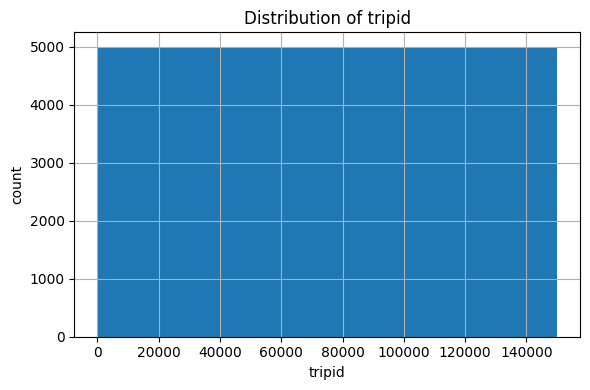

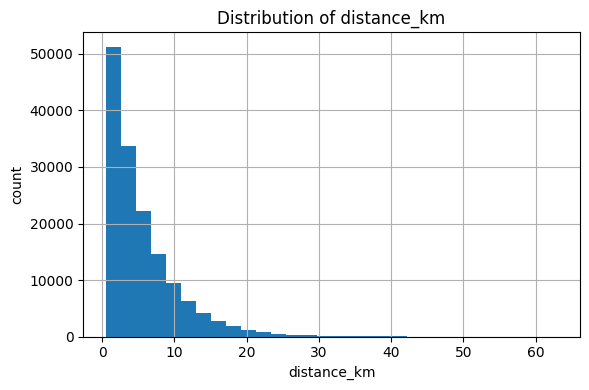

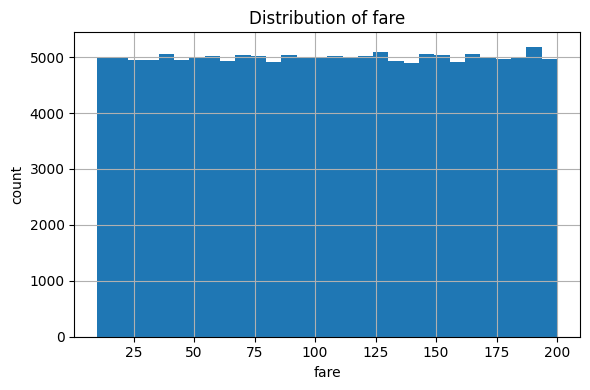

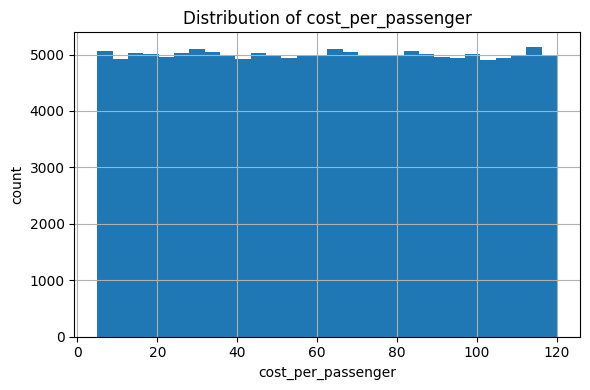

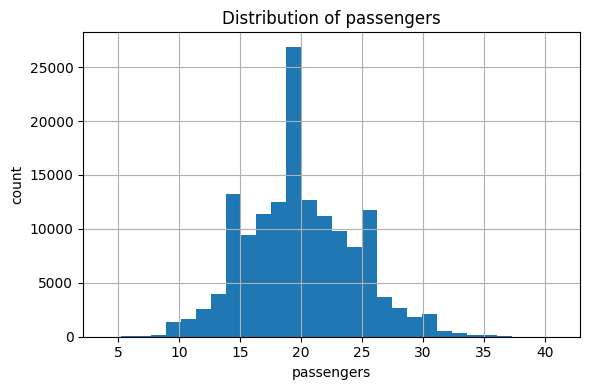

In [15]:
#Distributions Visualisations
num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(6,4))
    df_raw[col].dropna().hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


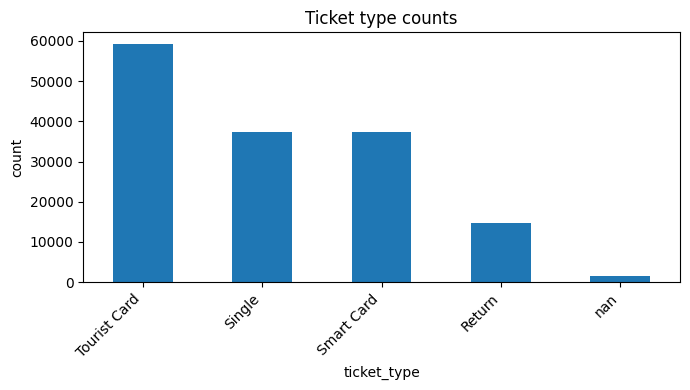

In [16]:
#Ticket type counts
if ticket_col:
    plt.figure(figsize=(7,4))
    df_raw[ticket_col].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title("Ticket type counts")
    plt.xlabel(ticket_col)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


###Comparisons (Group Analysis)

In [18]:
#Group by ticket type
if ticket_col:
    agg_dict = {}
    if fare_col:      agg_dict[fare_col] = ['count', 'mean', 'median']
    if distance_col:  agg_dict[distance_col] = ['mean', 'median']
    if passenger_col: agg_dict[passenger_col] = ['mean', 'sum']

    ticket_summary = df_raw.groupby(ticket_col).agg(agg_dict)
    ticket_summary.columns = ['_'.join([c for c in tup if c]) for tup in ticket_summary.columns.to_flat_index()]
    ticket_summary = ticket_summary.sort_values(ticket_summary.columns[0], ascending=False)
    display(ticket_summary)


,fare_count,fare_mean,fare_median,distance_km_mean,distance_km_median,passengers_mean,passengers_sum
ticket_type,,,,,,,
Tourist Card,59193,105.113736,105.380,5.512996,3.97,20.000000,1171860.0
Single,37341,105.440164,105.600,5.446286,3.95,20.009496,739631.0
Smart Card,37244,105.055084,104.765,5.500439,3.96,20.016516,738069.0
Return,14722,104.588311,104.575,5.486720,3.97,19.975590,291324.0


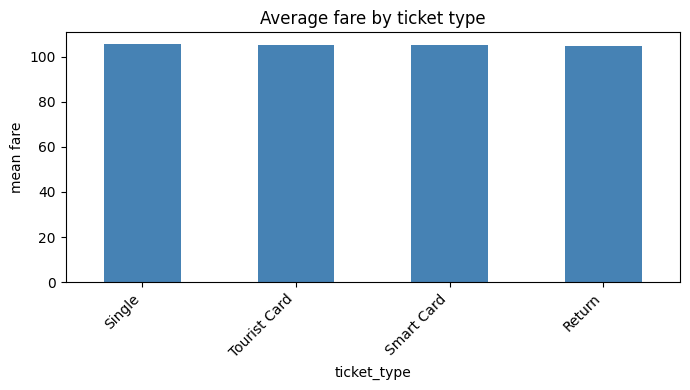

In [20]:
#visual for avg fare by ticket
if ticket_col and fare_col:
    plt.figure(figsize=(7,4))
    df_raw.groupby(ticket_col)[fare_col].mean().sort_values(ascending=False).plot(kind='bar', color='steelblue')
    plt.title("Average fare by ticket type")
    plt.xlabel(ticket_col)
    plt.ylabel(f"mean {fare_col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


###Station Popularity

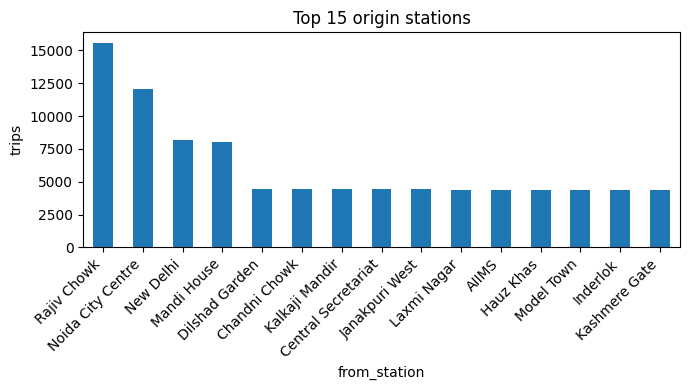

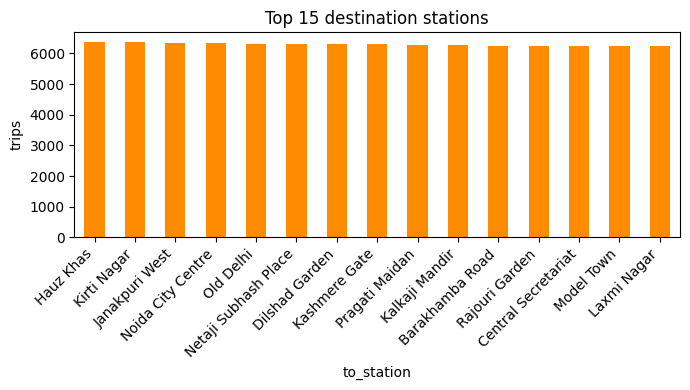

In [21]:
#origin station counts
if from_col:
    plt.figure(figsize=(7,4))
    df_raw[from_col].value_counts().head(15).plot(kind='bar')
    plt.title("Top 15 origin stations")
    plt.xlabel(from_col)
    plt.ylabel("trips")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#destination
if to_col:
    plt.figure(figsize=(7,4))
    df_raw[to_col].value_counts().head(15).plot(kind='bar', color='darkorange')
    plt.title("Top 15 destination stations")
    plt.xlabel(to_col)
    plt.ylabel("trips")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


###Relationship Plots

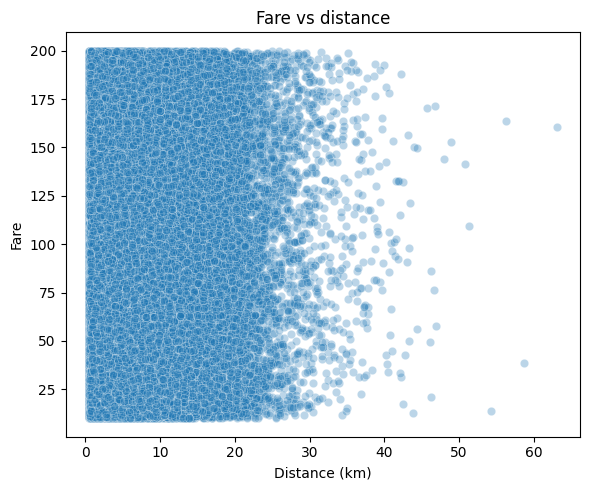

In [22]:
# fare vs distance
if fare_col and distance_col:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df_raw, x=distance_col, y=fare_col, alpha=0.3)
    plt.title("Fare vs distance")
    plt.xlabel("Distance (km)")
    plt.ylabel("Fare")
    plt.tight_layout()
    plt.show()


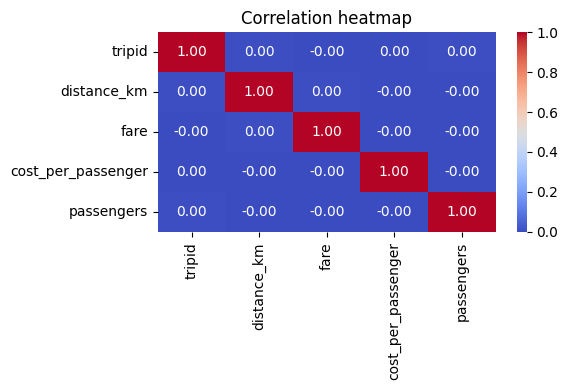

In [23]:
# correlation heatmap
num_df = df_raw.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.show()


###Time Based Analysis

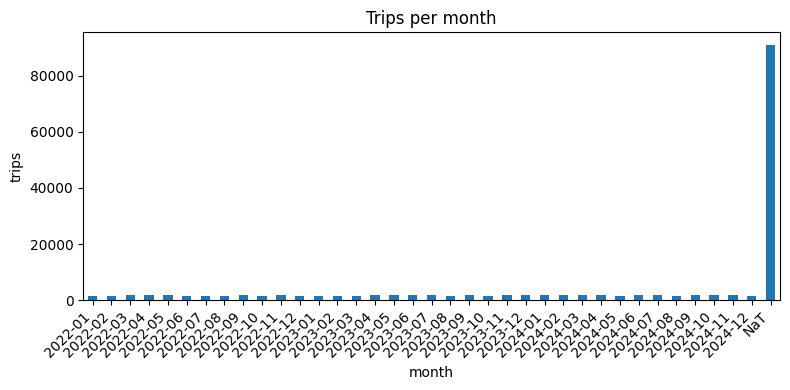

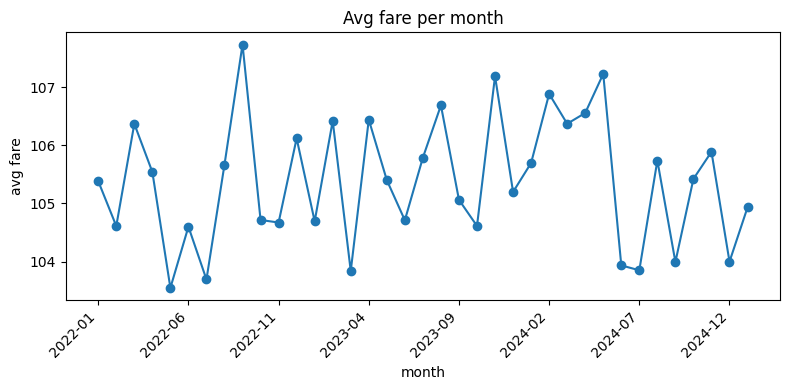

In [24]:
# trips per month, avg fare per month
if date_col:
    df_raw['year_month'] = df_raw[date_col].dt.to_period('M').astype(str)
    trips_by_month = df_raw['year_month'].value_counts().sort_index()

    plt.figure(figsize=(8,4))
    trips_by_month.plot(kind='bar')
    plt.title("Trips per month")
    plt.xlabel("month")
    plt.ylabel("trips")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    if fare_col:
        avg_fare_month = df_raw.groupby('year_month')[fare_col].mean()
        plt.figure(figsize=(8,4))
        avg_fare_month.plot(marker='o')
        plt.title("Avg fare per month")
        plt.xlabel("month")
        plt.ylabel("avg fare")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


###Saved Cleaned Outputs

In [28]:
# Cell 20: save
out_dir = data.parent
df_raw.to_csv(out_dir / "delhi_metro_cleaned.csv", index=False)

if ticket_col:
    ticket_summary.to_csv(out_dir / "delhi_metro_by_ticket_type.csv")

print("Saved to:", out_dir)

Saved to: /
